We will be using [Spam Detection Dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset) from Kaggle and build models to predict whether a text is spam or not.

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# from google.colab import files
# uploaded = files.upload()

df = pd.read_csv("https://raw.githubusercontent.com/AashitaK/datasets/main/spam.csv", encoding="latin-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df = df.dropna(how="any", axis=1)
df.columns = ['label', 'text']
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df['label'].value_counts()

,count
label,
ham,4825
spam,747


In [7]:
4825/(4825+747), 747/(4825+747)

(0.8659368269921034, 0.13406317300789664)

In [8]:
df['text_length'] = df['text'].apply(lambda x: len(x.split(' ')))
df.head()

,label,text,text_length
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [9]:
df['text_length'].min(), df['text_length'].max()

(1, 171)

In [10]:
from sklearn.model_selection import train_test_split
# default is 75% / 25% train-test split
X = df['text']
y = df['label'].replace({'spam': 1, 'ham': 0})
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

<ipython-input-10-d0a8031995d0>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['label'].replace({'spam': 1, 'ham': 0})


Now, let's build a Logistic classifier and train a neutral network

In [11]:
import re
def clean_text(text):
    """
    Applies some pre-processing on the given text.

    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    """

    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)
    text = re.sub(r"\"", "", text)

    # convert text to lowercase
    text = text.strip().lower()

    # replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    return text

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression

# Vectorization
vectorizer = CountVectorizer(stop_words="english",
                             preprocessor=clean_text)

X_train_vectorized = vectorizer.fit_transform(X_train)
X_valid_vectorized = vectorizer.transform(X_valid)

# Model training
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
y_predicted = model.predict(X_valid_vectorized)

# Evaluation
acc = accuracy_score(y_valid, y_predicted)

print("Accuracy on the Spam detection dataset: {:.2f}".format(acc*100))

Accuracy on the Spam detection dataset: 97.77


In [13]:
# Compute confusin matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_valid, y_predicted)
print('Confusion Matrix\n', confusion)

Confusion Matrix
 [[1195    1]
 [  30  167]]


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_valid, y_predicted)
precision = precision_score(y_valid, y_predicted)
recall = recall_score(y_valid, y_predicted)
f1 = f1_score(y_valid, y_predicted)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)

Accuracy: 0.9777458722182341
Precision: 0.9940476190476191
Recall: 0.8477157360406091
F1: 0.915068493150685


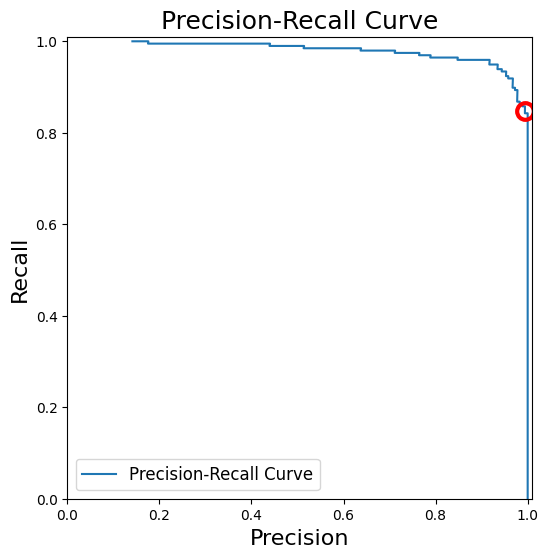

In [15]:
from sklearn.metrics import precision_recall_curve

y_scores = model.decision_function(X_valid_vectorized)
precision, recall, thresholds = precision_recall_curve(y_valid, y_scores)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure(figsize=(6, 6))
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.title('Precision-Recall Curve', fontsize=18)
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.legend(loc='lower left', fontsize=12)
plt.show()

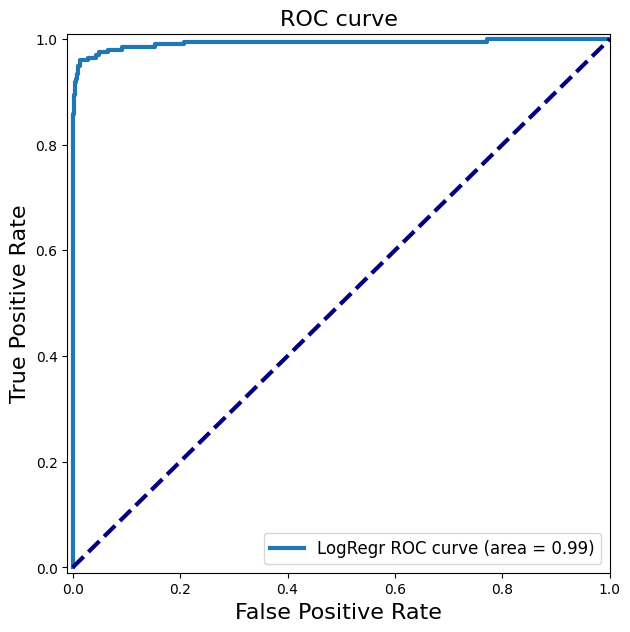

In [16]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_valid, y_scores)
roc_auc_lr = auc(fpr, tpr)

plt.figure(figsize=(7, 7))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

In [17]:
# Vectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_words = 50000
tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(X)

X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_valid_tokens = tokenizer.texts_to_sequences(X_valid)

max_tokens = 160
X_train_pad = pad_sequences(X_train_tokens, maxlen=max_tokens)
X_valid_pad = pad_sequences(X_valid_tokens, maxlen=max_tokens)

In [18]:
from keras.models import Sequential
from keras import Input
from keras.layers import Dense, Embedding, Dropout, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf

In [19]:
# Define model
model = Sequential()
embedding_size = 32
model.add(Embedding(input_dim=num_words, output_dim=embedding_size, input_length=max_tokens))
model.add(Dropout(0.1))
model.add(GlobalAveragePooling1D())
model.add(Dense(units=32, activation='relu')) # Hidden layer
model.add(Dense(units=16, activation='relu')) # Hidden layer
model.add(Dense(units=2, activation='softmax')) # Output layer

# Compile model
model.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(1e-4), metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [20]:
model.fit(X_train_pad, y_train, batch_size=16, epochs=50, verbose=1, validation_data=(X_valid_pad, y_valid))

Epoch 1/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8644 - loss: 0.4873 - val_accuracy: 0.8586 - val_loss: 0.3932
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8642 - loss: 0.3810 - val_accuracy: 0.8586 - val_loss: 0.3930
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8656 - loss: 0.3780 - val_accuracy: 0.8586 - val_loss: 0.3909
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8724 - loss: 0.3625 - val_accuracy: 0.8586 - val_loss: 0.3900
Epoch 5/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8739 - loss: 0.3582 - val_accuracy: 0.8586 - val_loss: 0.3885
Epoch 6/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8622 - loss: 0.3786 - val_accuracy: 0.8586 - val_loss: 0.3864
Epoch 7/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8737 - loss: 0.3565 - val_accuracy: 0.8586 - val_loss: 0.3842
Epoch 8/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8681 - loss: 0.3637 - val_accu

In [21]:
y_predicted = np.argmax(model.predict(X_valid_pad), axis=-1)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [22]:
confusion = confusion_matrix(y_valid, y_predicted)
print('Confusion Matrix\n', confusion)

Confusion Matrix
 [[1194    2]
 [  26  171]]


In [23]:
accuracy = accuracy_score(y_valid, y_predicted)
precision = precision_score(y_valid, y_predicted)
recall = recall_score(y_valid, y_predicted)
f1 = f1_score(y_valid, y_predicted)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)

Accuracy: 0.9798994974874372
Precision: 0.9884393063583815
Recall: 0.868020304568528
F1: 0.9243243243243243


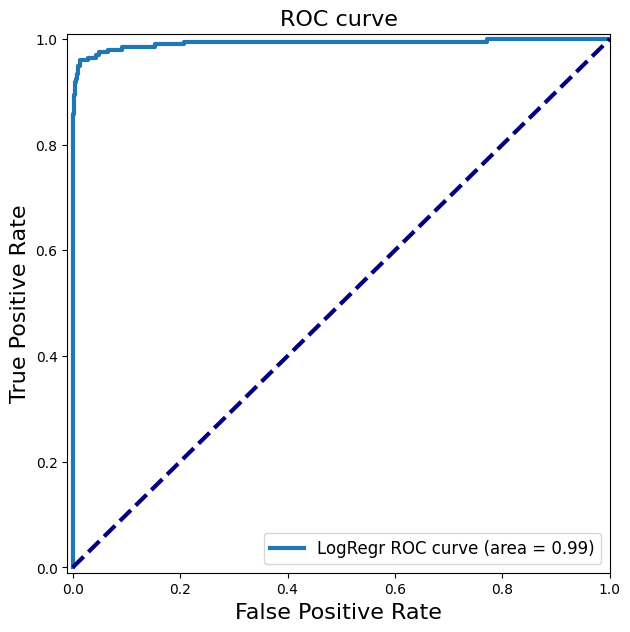

In [24]:
fpr, tpr, _ = roc_curve(y_valid, y_scores)
roc_auc_lr = auc(fpr, tpr)

plt.figure(figsize=(7, 7))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()